In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from torch.ao.nn.quantized.functional import threshold
from xgboost import XGBRegressor
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [15]:
warnings.filterwarnings('ignore')

In [16]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [17]:
train_df_final.head()

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,surface_temp_avg_percentile,humidity_avg_percentile,slp_avg_percentile,surface_temp_avg_station_z,humidity_avg_station_z,slp_avg_station_z,surface_temp_avg_station_month_mean,surface_temp_avg_month_resid,humidity_avg_station_month_mean,humidity_avg_month_resid
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,0.017213,0.999852,1,9.426812,...,0.003503,0.088334,0.991852,-1.749027,-1.558082,0.865451,-1.916532,-3.666801,63.114471,-16.239471
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,0.034422,0.999407,2,9.437325,...,0.002894,0.075046,0.994822,-1.764568,-1.644158,0.899437,-1.916532,-3.845968,63.114471,-17.614471
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,0.051620,0.998667,3,9.448699,...,0.004150,0.057455,0.997411,-1.726258,-1.764143,0.941579,-1.916532,-3.404301,63.114471,-19.531138
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,0.068802,0.997630,4,9.460926,...,0.013250,0.171946,0.972434,-1.604822,-1.164218,0.742909,-1.916532,-2.004301,63.114471,-9.947805
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,0.085965,0.996298,5,9.473997,...,0.020256,0.035676,0.896398,-1.558921,-1.951946,0.563076,-1.916532,-1.475134,63.114471,-22.531138


# Dataset Splitting

In [18]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna Setup

In [19]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 32,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [20]:
study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
study.optimize(objective, n_trials=300, n_jobs=-1)
print("Best trial:")
print(f"  RMSE: {study.best_value:.5f}")
print(f"  Params: {study.best_params}")

best_params = study.best_params.copy()
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 32,
    'verbosity': 0
})

[I 2025-05-14 21:41:38,036] A new study created in memory with name: xgb_reg_opt
[I 2025-05-14 21:42:14,954] Trial 2 finished with value: 1.3753508685091846 and parameters: {'n_estimators': 1602, 'learning_rate': 0.0824405661211089, 'max_depth': 10, 'subsample': 0.7946537931515505, 'colsample_bytree': 0.5577158897772738, 'min_child_weight': 0.003507904693197416, 'gamma': 0.08958179406394645, 'reg_alpha': 0.0011127457492798973, 'reg_lambda': 3.256483524457018}. Best is trial 2 with value: 1.3753508685091846.
[I 2025-05-14 21:42:26,227] Trial 8 finished with value: 1.4833322747173987 and parameters: {'n_estimators': 2010, 'learning_rate': 0.01712577898527081, 'max_depth': 3, 'subsample': 0.6430748334562228, 'colsample_bytree': 0.9677847208145361, 'min_child_weight': 0.003973185512746554, 'gamma': 3.1005308399358454e-07, 'reg_alpha': 3.681574665513589e-05, 'reg_lambda': 1.3023054573595734e-08}. Best is trial 2 with value: 1.3753508685091846.
[I 2025-05-14 21:42:44,887] Trial 1 finished wi

Best trial:
  RMSE: 1.17160
  Params: {'n_estimators': 7721, 'learning_rate': 0.02445056203934129, 'max_depth': 5, 'subsample': 0.8315968977205844, 'colsample_bytree': 0.8653287052422697, 'min_child_weight': 0.11264069349165448, 'gamma': 0.00015342523339293188, 'reg_alpha': 1.179259784970187e-05, 'reg_lambda': 4.436773118433934}


In [21]:
# best_params = {'n_estimators': 7721, 'learning_rate': 0.02445056203934129, 'max_depth': 5, 'subsample': 0.8315968977205844, 'colsample_bytree': 0.8653287052422697, 'min_child_weight': 0.11264069349165448, 'gamma': 0.00015342523339293188, 'reg_alpha': 1.179259784970187e-05, 'reg_lambda': 4.436773118433934}

# Train

In [22]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.8469 | RMSE: 1.1716


# Feature Importance

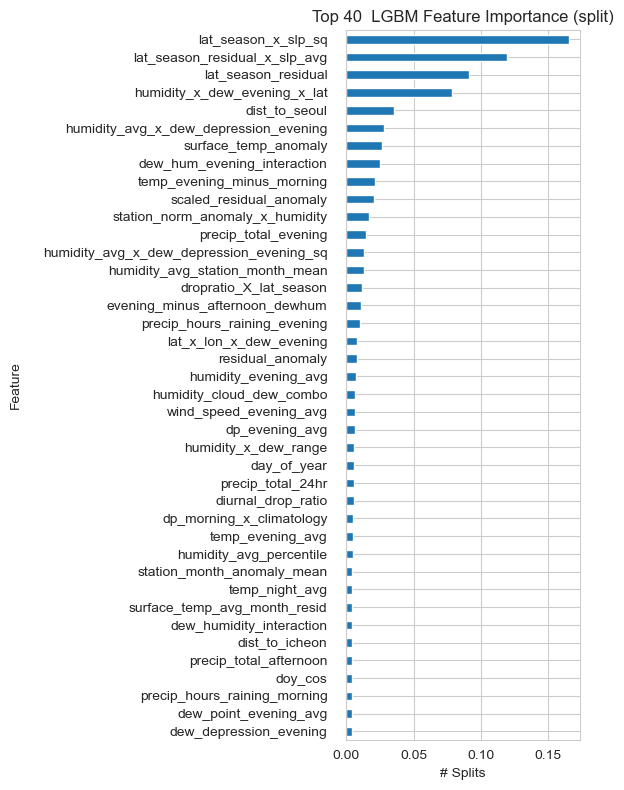

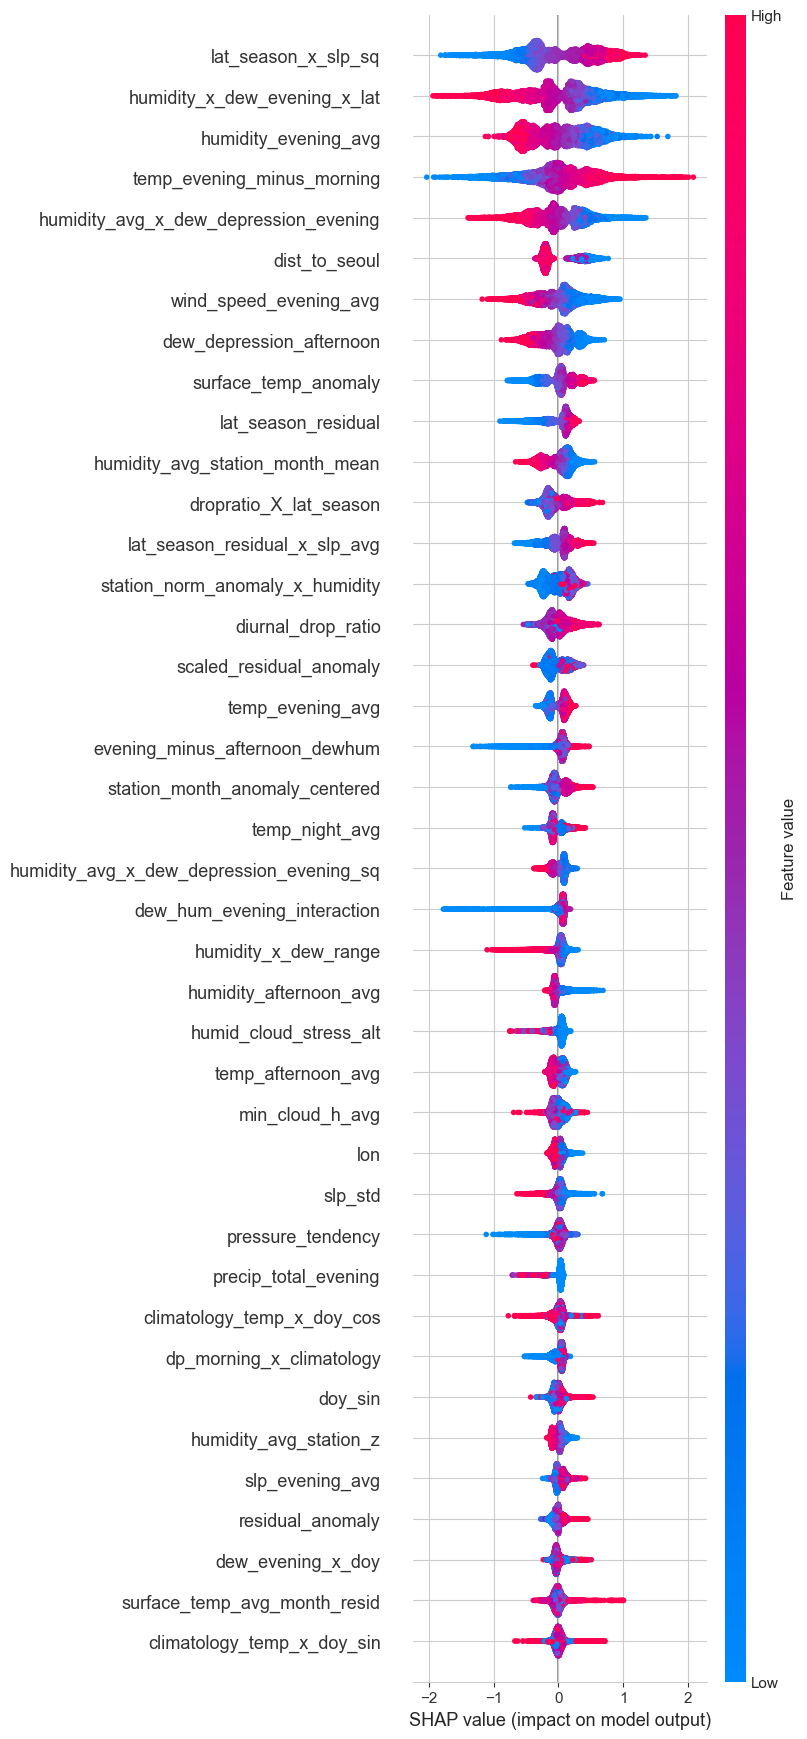

In [23]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 40

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N}  LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [24]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 40 XGB Importances (split):
lat_season_x_slp_sq                         0.165249
lat_season_residual_x_slp_avg               0.119025
lat_season_residual                         0.091425
humidity_x_dew_evening_x_lat                0.078145
dist_to_seoul                               0.035393
humidity_avg_x_dew_depression_evening       0.027777
surface_temp_anomaly                        0.026262
dew_hum_evening_interaction                 0.025168
temp_evening_minus_morning                  0.021271
scaled_residual_anomaly                     0.020678
station_norm_anomaly_x_humidity             0.016778
precip_total_evening                        0.014906
humidity_avg_x_dew_depression_evening_sq    0.013215
humidity_avg_station_month_mean             0.013205
dropratio_X_lat_season                      0.011998
evening_minus_afternoon_dewhum              0.010559
precip_hours_raining_evening                0.010196
lat_x_lon_x_dew_evening                     0.007883
residual_anoma

# Feature Selection with SHAP

In [25]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
cloud_cover_night_avg                  0.033600
cloud_cover_avg                        0.033519
wind_speed_morning_avg                 0.032608
climatology_temp                       0.031077
wind_speed_night_avg                   0.030478
humidity_range                         0.028874
slp_afternoon_range                    0.028838
cloud_cover_evening_var                0.028450
day_length                             0.028208
humidity_night_avg                     0.026158
humidity_morning_avg                   0.025840
doy_cos                                0.024334
cloud_cover_afternoon_var              0.023528
dew_depression_night                   0.023204
cloud_cover_night_var                  0.022337
humidity_avg_month_resid               0.022033
precip_total_24hr                      0.022001
lat_season_mod                         0.021772
dew_point_avg                          0.021750
dew_point_morning_avg                  0.020724
slp_avg        

# Predict with Test Dataset

In [26]:
y_test_pred = xgb_model.predict(X_test)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_{now}.csv', index=False)